In [ ]:
import os
import torch
import torch.nn.functional as F
os.environ["TORCH"]=torch.__version__

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

In [ ]:
import torch_geometric
from torch_geometric.datasets import Planetoid
from torch_geometric.data import HeteroData, download_url, extract_zip
from torch_geometric.transforms import RandomLinkSplit,ToUndirected

In [ ]:
from torch_geometric.transforms import NormalizeFeatures

dataset=Planetoid(root='data/Planetoid',name='Cora',transform=NormalizeFeatures())
print(len(dataset))
print(dataset.num_features)
print(dataset.num_classes)
print(dataset.num_node_features)
print(dataset.num_edge_features)


Processing...


1
1433
7
1433
0


Done!


In [ ]:
print(dataset[0])
print(dataset[0].x)
print(dataset[0].y)
print(dataset[0].edge_index)

# print(dataset[0].edge_attr)

print(dataset[0].num_features)
print(dataset[0].num_node_features)
print(dataset[0].num_edge_features)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([3, 4, 4,  ..., 3, 3, 3])
tensor([[ 633, 1862, 2582,  ...,  598, 1473, 2706],
        [   0,    0,    0,  ..., 2707, 2707, 2707]])
1433
1433
0


In [ ]:
import torch.nn as nn
from torch_geometric.nn import GCNConv

In [ ]:
class gnn(nn.Module):
  def __init__(self):
    super().__init__()
    torch.manual_seed(69)
    self.c1=GCNConv(dataset.num_node_features,104)
    # self.c2=GCNConv(1024,512)
    # self.c3=GCNConv(512,256)
    self.c2=GCNConv(104,104)
    self.c3=GCNConv(104,64)
    # self.c3=GCNConv(64,32)
    self.c4=GCNConv(64,dataset.num_classes)

  def forward(self,x,edge_index):
    x=self.c1(x,edge_index)
    x=x.relu()
    x=F.dropout(x,p=0.2,training=self.training)

    x=self.c2(x,edge_index)
    x=x.relu()
    x=F.dropout(x,p=0.2,training=self.training)


    x=self.c3(x,edge_index)
    x=x.relu()
    x=F.dropout(x,p=0.2,training=self.training)

    x=self.c4(x,edge_index)
    return x

model=gnn()
print(model)


gnn(
  (c1): GCNConv(1433, 104)
  (c2): GCNConv(104, 104)
  (c3): GCNConv(104, 64)
  (c4): GCNConv(64, 7)
)


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

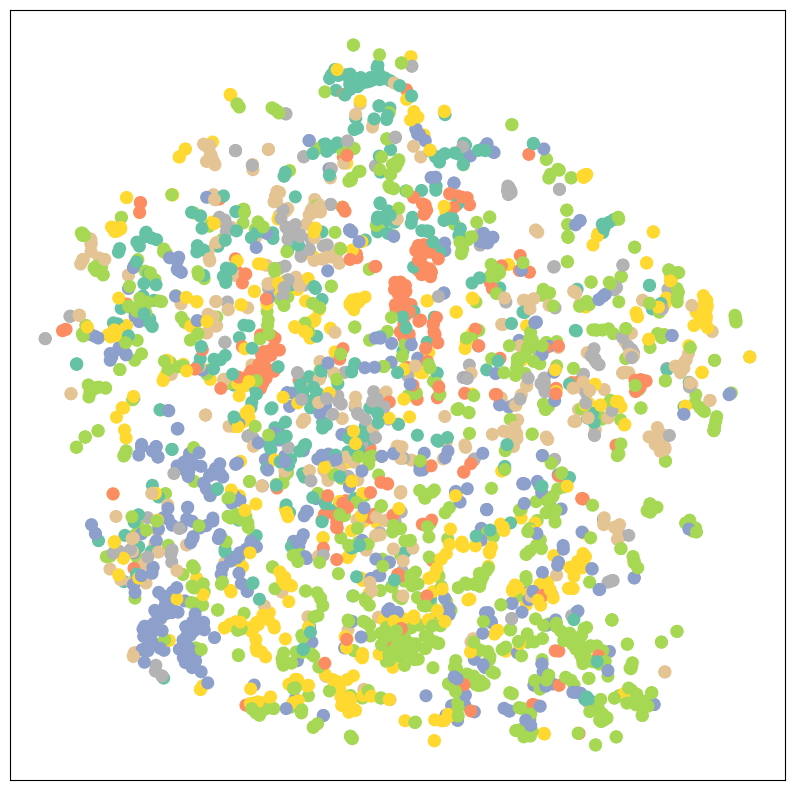

In [ ]:
model.eval()

out=model(dataset[0].x,dataset[0].edge_index)
visualize(out, color=dataset[0].y)

In [ ]:
# model=gnn()

optimizer=torch.optim.Adam(model.parameters(),lr=5e-4,weight_decay=1e-4)
criterion=torch.nn.CrossEntropyLoss()

def train():
  model.train()
  optimizer.zero_grad()
  out=model(dataset[0].x,dataset[0].edge_index)
  loss=criterion(out[dataset[0].train_mask],dataset[0].y[dataset[0].train_mask])
  loss.backward()
  optimizer.step()
  return loss

def test():
  model.eval()
  out=model(dataset[0].x,dataset[0].edge_index)
  pred=out.argmax(dim=1)
  test_correct=(pred[dataset[0].test_mask]==dataset[0].y[dataset[0].test_mask]).sum()
  test_acc=test_correct.sum()/dataset[0].test_mask.sum()
  return test_acc

In [ ]:
maxx=0
anss=0

for epoch in range(110):
    loss=train()

    acc=test()
    maxx=max(maxx,acc)
    if maxx==acc:
        anss=epoch

    # if loss < 0.2:
    #     break

    print(f' {epoch} "=>"   /// {acc}')

print (f"{maxx},{anss}");

 0 "=>"   /// 0.18799999356269836
 1 "=>"   /// 0.26899999380111694
 2 "=>"   /// 0.2639999985694885
 3 "=>"   /// 0.2840000092983246
 4 "=>"   /// 0.32199999690055847
 5 "=>"   /// 0.34700000286102295
 6 "=>"   /// 0.3569999933242798
 7 "=>"   /// 0.3569999933242798
 8 "=>"   /// 0.375
 9 "=>"   /// 0.3959999978542328
 10 "=>"   /// 0.4320000112056732
 11 "=>"   /// 0.4830000102519989
 12 "=>"   /// 0.5329999923706055
 13 "=>"   /// 0.5809999704360962
 14 "=>"   /// 0.6140000224113464
 15 "=>"   /// 0.6380000114440918
 16 "=>"   /// 0.6499999761581421
 17 "=>"   /// 0.6489999890327454
 18 "=>"   /// 0.6399999856948853
 19 "=>"   /// 0.6320000290870667
 20 "=>"   /// 0.6240000128746033
 21 "=>"   /// 0.6380000114440918
 22 "=>"   /// 0.6510000228881836
 23 "=>"   /// 0.6570000052452087
 24 "=>"   /// 0.6579999923706055
 25 "=>"   /// 0.6620000004768372
 26 "=>"   /// 0.6629999876022339
 27 "=>"   /// 0.6669999957084656
 28 "=>"   /// 0.6610000133514404
 29 "=>"   /// 0.6539999842643738

In [ ]:
acc=test()
print(f'Test Accuracy {acc:.4f}')

Test Accuracy 0.7960


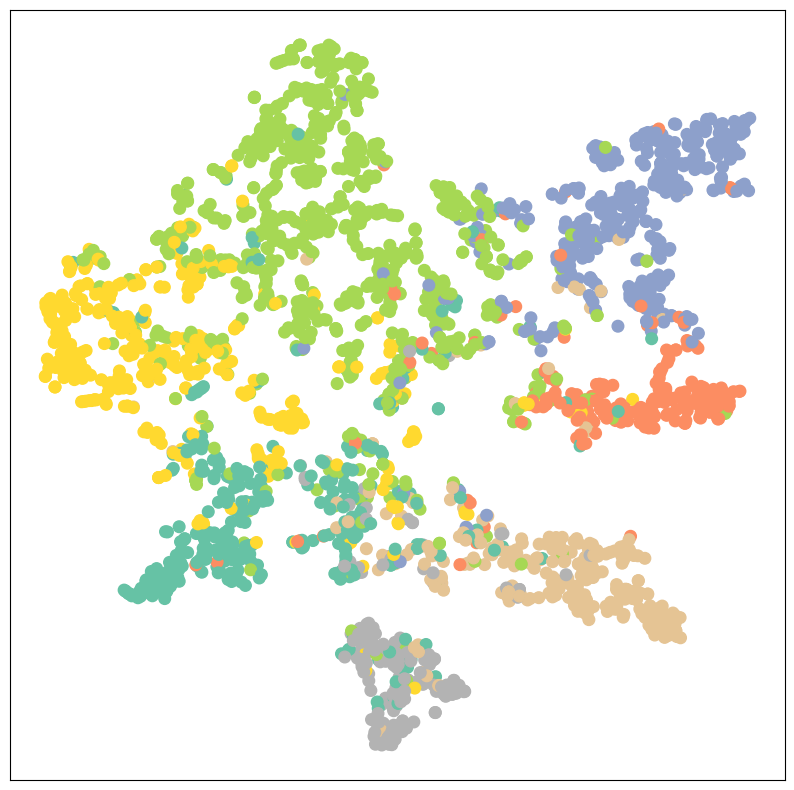

In [ ]:
model.eval()

out=model(dataset[0].x,dataset[0].edge_index)
visualize(out, color=dataset[0].y)

In [ ]:
maxxx,id=0,-1
for hidden in range(100,257,4):
  class gnn(nn.Module):
    def __init__(self):
      super().__init__()
      torch.manual_seed(69)
      self.c1=GCNConv(dataset.num_node_features,hidden)
      # self.c2=GCNConv(1024,512)
      # self.c3=GCNConv(512,256)
      self.c2=GCNConv(hidden,hidden)
      self.c3=GCNConv(hidden,64)
      # self.c3=GCNConv(64,32)
      self.c4=GCNConv(64,dataset.num_classes)

    def forward(self,x,edge_index):
      x=self.c1(x,edge_index)
      x=x.relu()
      x=F.dropout(x,p=0.2,training=self.training)

      x=self.c2(x,edge_index)
      x=x.relu()
      x=F.dropout(x,p=0.2,training=self.training)


      x=self.c3(x,edge_index)
      x=x.relu()
      x=F.dropout(x,p=0.2,training=self.training)

      x=self.c4(x,edge_index)
      return x



  optimizer=torch.optim.Adam(model.parameters(),lr=5e-4,weight_decay=1e-4)
  criterion=torch.nn.CrossEntropyLoss()
  for epoch in range(150):
    loss=train()

    acc=test()
    maxx=max(maxx,acc)
    if maxx==acc:
        anss=epoch

    if maxx>maxxx:
      maxxx=maxx
      id=hidden

print(maxx)
print(id)


tensor(0.8050)
104
